# Synthetic Glacier: Preprocessing

Lets extract some data along an extended flowline for our Synthetic Glacier. Information we will extract:  
  * Surface profile from SRTM DEM,  
  * Bedrock profile from Faranotti et al. 2019
  * Surface Mass Balance (SMB) from Erik Young's Enhanced temperature index melt model. 

In [1]:
import os
import numpy as np
import geopandas as gpd
import contextily as ctx
import cartopy.crs as ccrs

import pickle 
import scipy.signal as signal
from scipy import linalg as LA
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import fiona
import rasterio
import rasterio.mask
from rasterio.io import MemoryFile
from rasterio.transform import Affine

plt.rcParams['text.usetex'] = True

In [2]:
def centerline_2_points(geom, dx=30):
    # https://stackoverflow.com/questions/34906124/interpolating-every-x-distance-along-multiline-in-shapely
    num_vert = int(round(geom.length / dx))
    if num_vert == 0: 
        num_vert = 1
    multipoint = [geom.interpolate(float(n)/num_vert,normalized=True) for n in range(num_vert + 1)] 
    Latx = [multipoint[i].x for i in range(len(multipoint))]
    Laty = [multipoint[i].y for i in range(len(multipoint))]
    gdf  = gpd.GeoDataFrame(geometry=gpd.points_from_xy(Latx,Laty))
    return gdf

def lstq(x,y,order):
    A     = np.vstack([x**i for i in range(0,order)]).T
    coefs = LA.lstsq(A,y)[0]
    return coefs

In [3]:
FL_dir = '/Users/andrewnolan/sfuvault/LilKluane/flowlines/'

# What tributary are we looking at?
SURGE_TRIB = True

if SURGE_TRIB:
    #FL_fp = os.path.join(FL_dir,'alexis/centerlines_postsurge_UTM7N.shp')
    FL_fp = os.path.join(FL_dir,'alexis/centerlines_postsurge_UTM7N_extended.shp')
    # Read the centerline for Little Kluane
    LK_FL = gpd.read_file(FL_fp)
    LK_CP = centerline_2_points(LK_FL[LK_FL['MAIN'] == 1], dx=100)
    # For whatever reason we need to flip the oggm flowline
    LK_CP = LK_CP.sort_index(axis=0,ascending=False).reset_index(drop=True)
else:
    FL_fp = os.path.join(FL_dir,'manual/main/Little_Kluan_FL_main.shp')
    # Read the centerline for Little Kluane
    LK_FL = gpd.read_file(FL_fp)
    LK_CP = centerline_2_points(LK_FL, dx=100)

LK_CP['UTM_N'] = None
LK_CP['UTM_E'] = None

for i,row in enumerate(LK_CP['geometry']):
    LK_CP.iloc[i,1] = row.y
    LK_CP.iloc[i,2] = row.x   
prof_coords = [(x,y) for x, y in zip(LK_CP.UTM_E, LK_CP.UTM_N)]


In [4]:
BED_DEM_fp  = '/Users/andrewnolan/sfuvault/LilKluane/DEMS/Faranotti_2020/RGI60-01.16198_BDEM.tif'

EB_2007_fp = '/Users/andrewnolan/sfuvault/LilKluane/DEMS/EB/dem_2007.tif'
SRTM_fp    = '/Users/andrewnolan/sfuvault/LilKluane/DEMS/SRTM/AST_merge/ASTGTMV003_MERGED_UTM7N.tif'
GC_Surf_fp = '/Users/andrewnolan/sfuvault/LilKluane/DEMS/Faranotti_2020/surface_DEM_RGI60-01.16198.tif'

#THIC_DEM_fp = '/Users/andrewnolan/sfuvault/LilKluane/DEMS/Faranotti_2020/RGI60-01.16198_thickness.tif'
base_img_fp = '/Users/andrewnolan/Documents/SFU/courses/EASC_605/Projects/project_3/geodata/T07VEH_20190908T205019_B08.jp2'

In [5]:
with rasterio.open(EB_2007_fp) as src:
    LK_CP['EB_2007'] = [x for x in src.sample(prof_coords)]
    LK_CP['EB_2007'] = LK_CP.apply(lambda x: x['EB_2007'][0], axis=1)

with rasterio.open(SRTM_fp) as src:
    LK_CP['SRTM'] = [x for x in src.sample(prof_coords)]
    LK_CP['SRTM'] = LK_CP.apply(lambda x: x['SRTM'][0], axis=1)

with rasterio.open(GC_Surf_fp) as src:
    LK_CP['GC_Surf'] = [x for x in src.sample(prof_coords)]
    LK_CP['GC_Surf'] = LK_CP.apply(lambda x: x['GC_Surf'][0], axis=1)
    
with rasterio.open(BED_DEM_fp) as src:
    bed_nodata = src.nodata
    LK_CP['bedprof'] = [x for x in src.sample(prof_coords)]
    LK_CP['bedprof'] = LK_CP.apply(lambda x: x['bedprof'][0], axis=1)

# with rasterio.open(THIC_DEM_fp) as src:
#     LK_CP['thickness'] = [x for x in src.sample(prof_coords)]
#     LK_CP['thickness'] = LK_CP.apply(lambda x: x['thickness'][0], axis=1)

# Replace nodata with np.nan
LK_CP = LK_CP.replace([-9999.0, 0.0, bed_nodata],np.nan)


# Raw Data from DEMs

First things first, lets take create a flow following x-coordinate vector.

In [6]:
# x-coordinate in km 
x_coord = LK_CP.index.to_numpy() * 100.0 / 1000.0

Great. Let's plot the inital data to figure out whats going on. 

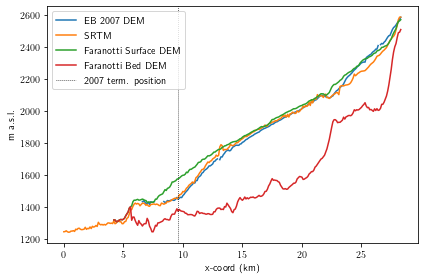

In [7]:
fig, ax = plt.subplots()

ax.plot(x_coord, LK_CP['EB_2007'], label='EB 2007 DEM')
ax.plot(x_coord, LK_CP['SRTM']   , label='SRTM')
ax.plot(x_coord, LK_CP['GC_Surf'], label='Faranotti Surface DEM')
ax.plot(x_coord, LK_CP['bedprof'], label='Faranotti Bed DEM')

ax.set_ylabel('m a.s.l.')
ax.set_xlabel('x-coord (km)')


ax.axvline(9.6, label='2007 term. position',c='k', ls=':', lw=0.75)
ax.legend()

plt.tight_layout()

fig.savefig('../plots/DEM_inqury.png',dpi=400,bbox_inches='tight',facecolor='w')

__Note__: Because Faranotit et al 2019 assume Little Kluane to be connected to the main Kluane Glacier, the ice thickness never reaches zero at the glacier margin. As a crude appoximation, we assume the glacier reaches zero ice-thickness arounf ~10km. Therefore, we manually force the bed and surface profiles to be equal after that point. 

In [8]:
# First lets create an empty vector where we will store the amalgamted 
# raw surface and bed profiles 
surface = np.zeros_like(LK_CP['EB_2007'])
bedprof = np.zeros_like(LK_CP['EB_2007'])

# Get a bool array of where Bed Profile from Faranotti is defined
bed_mask  = gpd.pd.isna(LK_CP['bedprof'])

# Get a boolean array where surf Profile from EB make sense is defined
surf_mask = x_coord > 9.6


# We'll use the faranotti bed where it's defined. After that (downstream)
# the faranotti bed DEM doesn't extend to full flowline length so we need
# to the regular old SRTM elevation. 
bedprof[~surf_mask]  = LK_CP['SRTM'][~surf_mask]
bedprof[surf_mask] = LK_CP['bedprof'][surf_mask]

# We'll use the EB surface DEM from 2007 except for the first 10 km of
# the flowline. As detailed above since Faranotti results think LK and 
# the main Kluane are connected, the ice thickness ner goes to zero, so
# we will just manually force it to by setting the surface and bed 
# elevations equal for the first 10 km. 
surface[surf_mask]  = LK_CP['EB_2007'][surf_mask]
surface[~surf_mask] = bedprof[~surf_mask]

Great. Lets take a quick look at our extract (raw) surface and bed profiles to make sure everything looks reasonable. 

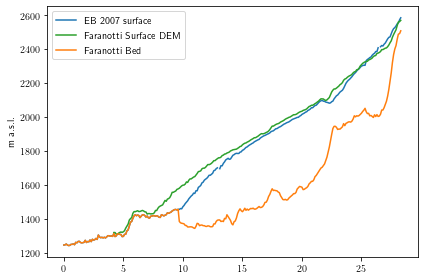

In [9]:
fig, ax = plt.subplots(1,1)

ax.plot(x_coord,surface,c='tab:blue', label='EB 2007 surface')
ax.plot(x_coord, LK_CP['GC_Surf'], c='tab:green', label='Faranotti Surface DEM')

#ax.plot(x_coord[-5:], surface[-5:],'r',label='Problematic section?')
ax.plot(x_coord,bedprof,c='tab:orange', label='Faranotti Bed')   
ax.legend()

ax.set_ylabel('m a.s.l.')

fig.tight_layout()
fig.savefig('../plots/bed_correction_check.png', dpi=300,bbox_inches='tight',facecolor='w')

Now, lets fit a polynomial to the surface and smooth the bed using a savgol filter. 

In [10]:
xx     = np.linspace(x_coord[-1],x_coord[0],surface.shape[0])    # [  ] new x-coord vector
dx     = xx.shape[0]-len(x_coord)                                # [  ] differnce in nx b/w original and new extend

# Empty extended surface (ss) and bed (bb) vectors to be filled
ss     = xx.copy()
bb     = xx.copy()

# Smooth Faranotti Bed Profile with Savgol Filter.
bb = signal.savgol_filter(x=bedprof,window_length=21, polyorder=5)   

# Fit 10th order polynomial to surface profile, but only where the 
# ice thickness is defined. 
ss = np.polyval(lstq(x_coord[(~np.isnan(surface)) & (surf_mask)], 
                     surface[(~np.isnan(surface)) & (surf_mask)], 10)[::-1], x_coord) 

# Correct the Surface, where bed is higher than surface
ss[~surf_mask] = bb[~surf_mask]

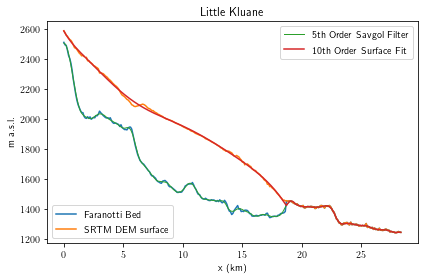

In [11]:
fig, ax = plt.subplots(1,1)

# obs = []; fit = []
# obs += ax1.plot(xx,bedprof[::-1],label='Faranotti Bed')
# obs += ax1.plot(xx,surface[::-1],label='SRTM DEM surface')

# fit += ax1.plot(xx,bb[::-1],label='5th Order Savgol Filter',lw=1.0)
# fit += ax1.plot(xx,ss[::-1],label='10th Order Surface Fit')

obs = []; fit = []
obs += ax.plot(xx,bedprof,label='Faranotti Bed')
obs += ax.plot(xx,surface,label='SRTM DEM surface')

fit += ax.plot(xx,bb,label='5th Order Savgol Filter',lw=1.0)
fit += ax.plot(xx,ss,label='10th Order Surface Fit')


leg1 = ax.legend(fit,[line.get_label() for line in fit],loc=1)
leg2 = ax.legend(obs,[line.get_label() for line in obs],loc=3)
ax.add_artist(leg1)

ax.set_xlabel('x (km)')
ax.set_ylabel('m a.s.l.')
ax.set_title('Little Kluane')

fig.tight_layout()
fig.savefig('../Plots/lilklu.png',dpi=600,bbox_inches='tight',facecolor='w')

## Save the extracted profiles

In [12]:
# write a new xx (x-cord) now in [m]
xx  = np.linspace(xx.min()*1e3,xx.max()*1e3,xx.shape[0])

In [13]:
np.savetxt('../Data/Topography/REF_BedTopo.dat'   , np.array([xx,bb]).T,fmt='%.3e')
np.savetxt('../Data/Topography/REF_SurfTopo.dat'  , np.array([xx,ss]).T,fmt='%.3e')

In [14]:
!HEAD ../Data/Topography/REF_BedTopo.dat

0.000e+00 1.246e+03
1.000e+02 1.246e+03
2.000e+02 1.246e+03
3.000e+02 1.245e+03
4.000e+02 1.245e+03
5.000e+02 1.246e+03
6.000e+02 1.247e+03
7.000e+02 1.249e+03
8.000e+02 1.251e+03
9.000e+02 1.254e+03


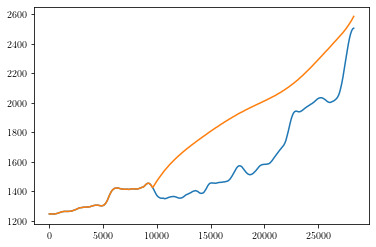

In [15]:
plt.plot(np.loadtxt('../Data/Topography/REF_BedTopo.dat')[:,0],
         np.loadtxt('../Data/Topography/REF_BedTopo.dat')[:,1])

plt.plot(np.loadtxt('../Data/Topography/REF_SurfTopo.dat')[:,0],
         np.loadtxt('../Data/Topography/REF_SurfTopo.dat')[:,1])

# Smooth Bed Profile for testing elevation dependent mass balance 

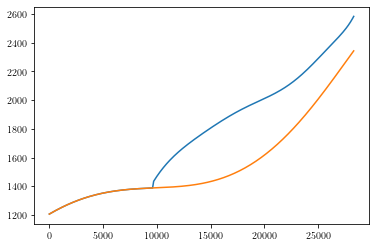

In [16]:
bb_smooth = np.polyval(np.polyfit(xx, bb, 5), xx)
ss_smooth = ss.copy()
ss_smooth[~surf_mask] = bb_smooth[~surf_mask]

plt.plot(xx, ss_smooth)
plt.plot(xx, bb_smooth)

In [17]:
np.savetxt('../Data/Topography/SMOOTH_BedTopo.dat'   , np.array([xx,bb_smooth]).T,fmt='%.3e')
np.savetxt('../Data/Topography/SMOOTH_SurfTopo.dat'  , np.array([xx,ss_smooth]).T,fmt='%.3e')

# Alternative Version of the Bed (05/12/2021)

In [18]:
FL_dir = '/Users/andrewnolan/sfuvault/LilKluane/flowlines/'

# What tributary are we looking at?
SURGE_TRIB = True

if SURGE_TRIB:
    #FL_fp = os.path.join(FL_dir,'alexis/centerlines_postsurge_UTM7N.shp')
    FL_fp = os.path.join(FL_dir,'alexis/centerlines_postsurge_UTM7N_extended.shp')
    # Read the centerline for Little Kluane
    LK_FL = gpd.read_file(FL_fp)
    LK_CP = centerline_2_points(LK_FL[LK_FL['MAIN'] == 1], dx=10)
    # For whatever reason we need to flip the oggm flowline
    LK_CP = LK_CP.sort_index(axis=0,ascending=False).reset_index(drop=True)
else:
    FL_fp = os.path.join(FL_dir,'manual/main/Little_Kluan_FL_main.shp')
    # Read the centerline for Little Kluane
    LK_FL = gpd.read_file(FL_fp)
    LK_CP = centerline_2_points(LK_FL, dx=10)

LK_CP['UTM_N'] = None
LK_CP['UTM_E'] = None

for i,row in enumerate(LK_CP['geometry']):
    LK_CP.iloc[i,1] = row.y
    LK_CP.iloc[i,2] = row.x   
prof_coords = [(x,y) for x, y in zip(LK_CP.UTM_E, LK_CP.UTM_N)]

In [19]:
with rasterio.open(EB_2007_fp) as src:
    LK_CP['EB_2007'] = [x for x in src.sample(prof_coords)]
    LK_CP['EB_2007'] = LK_CP.apply(lambda x: x['EB_2007'][0], axis=1)

with rasterio.open(SRTM_fp) as src:
    LK_CP['SRTM'] = [x for x in src.sample(prof_coords)]
    LK_CP['SRTM'] = LK_CP.apply(lambda x: x['SRTM'][0], axis=1)

with rasterio.open(GC_Surf_fp) as src:
    LK_CP['GC_Surf'] = [x for x in src.sample(prof_coords)]
    LK_CP['GC_Surf'] = LK_CP.apply(lambda x: x['GC_Surf'][0], axis=1)
    
with rasterio.open(BED_DEM_fp) as src:
    bed_nodata = src.nodata
    LK_CP['bedprof'] = [x for x in src.sample(prof_coords)]
    LK_CP['bedprof'] = LK_CP.apply(lambda x: x['bedprof'][0], axis=1)

# with rasterio.open(THIC_DEM_fp) as src:
#     LK_CP['thickness'] = [x for x in src.sample(prof_coords)]
#     LK_CP['thickness'] = LK_CP.apply(lambda x: x['thickness'][0], axis=1)

# Replace nodata with np.nan
LK_CP = LK_CP.replace([-9999.0, 0.0, bed_nodata],np.nan)


In [20]:
# x-coordinate in km 
x_dx10 = LK_CP.index.to_numpy() * 10.0 / 1000.0

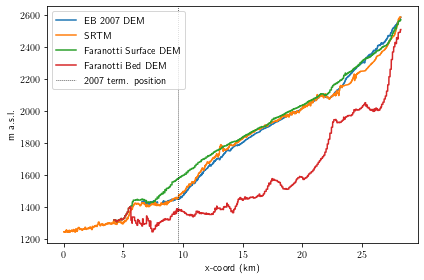

In [21]:
fig, ax = plt.subplots()

ax.plot(x_dx10, LK_CP['EB_2007'], label='EB 2007 DEM')
ax.plot(x_dx10, LK_CP['SRTM']   , label='SRTM')
ax.plot(x_dx10, LK_CP['GC_Surf'], label='Faranotti Surface DEM')
ax.plot(x_dx10, LK_CP['bedprof'], label='Faranotti Bed DEM')

ax.set_ylabel('m a.s.l.')
ax.set_xlabel('x-coord (km)')


ax.axvline(9.6, label='2007 term. position',c='k', ls=':', lw=0.75)
ax.legend()

plt.tight_layout()

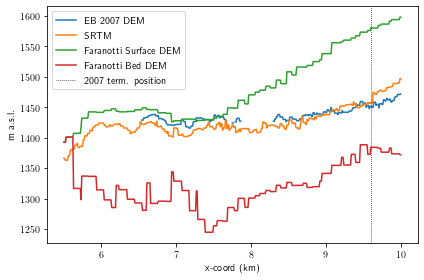

In [22]:
fig, ax = plt.subplots()

ax.plot(x_dx10[550:1001], LK_CP['EB_2007'][550:1001], label='EB 2007 DEM')
ax.plot(x_dx10[550:1001], LK_CP['SRTM'][550:1001]   , label='SRTM')
ax.plot(x_dx10[550:1001], LK_CP['GC_Surf'][550:1001], label='Faranotti Surface DEM')
ax.plot(x_dx10[550:1001], LK_CP['bedprof'][550:1001], label='Faranotti Bed DEM')

ax.set_ylabel('m a.s.l.')
ax.set_xlabel('x-coord (km)')


ax.axvline(9.6, label='2007 term. position',c='k', ls=':', lw=0.75)
ax.legend()

plt.tight_layout()

In [23]:
ss_smooth = signal.savgol_filter(x=LK_CP['SRTM'],   window_length=211, polyorder=5)
ss_poly   = np.polyval(np.polyfit(x_dx10, LK_CP['SRTM'], 10), x_dx10)
bb_smooth = signal.savgol_filter(x=LK_CP['bedprof'],window_length=211, polyorder=5)

correction = np.mean(ss_smooth[550:1001] - bb_smooth[550:1001])

In [24]:
ss_prop = np.concatenate([ss_smooth[x_dx10 <= 9.0], ss_poly[x_dx10 > 9.0]])
bb_prop = np.concatenate([ss_smooth[x_dx10 <= 9.0], (bb_smooth + correction)[x_dx10 > 9.0]])

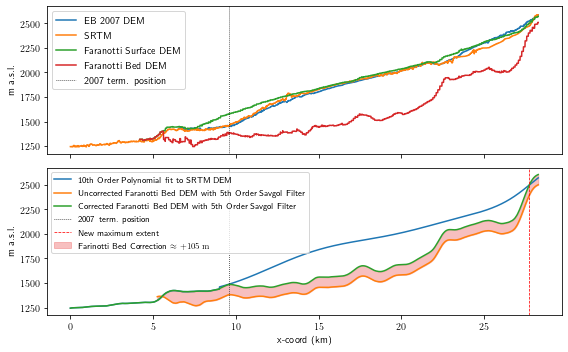

In [25]:
fig, ax = plt.subplots(2,1, sharex=True, sharey=True, figsize=(8,5))

ax[0].plot(x_dx10, LK_CP['EB_2007'], label='EB 2007 DEM')
ax[0].plot(x_dx10, LK_CP['SRTM']   , label='SRTM')
ax[0].plot(x_dx10, LK_CP['GC_Surf'], label='Faranotti Surface DEM')
ax[0].plot(x_dx10, LK_CP['bedprof'], label='Faranotti Bed DEM')

ax[0].set_ylabel('m a.s.l.')

ax[0].axvline(9.6, label='2007 term. position',c='k', ls=':', lw=0.75)
ax[0].legend()

ax[1].plot(x_dx10, ss_prop, label='10th Order Polynomial fit to SRTM DEM')
ax[1].plot(x_dx10, bb_smooth,label='Uncorrected Faranotti Bed DEM with 5th Order Savgol Filter')
ax[1].plot(x_dx10, bb_prop, label='Corrected Faranotti Bed DEM with 5th Order Savgol Filter')
ax[1].fill_between(x_dx10, 
                 bb_smooth, bb_prop, 
                 color='lightcoral', alpha=0.5, 
                 label=r'Farinotti Bed Correction $\approx + 105 \; \rm{m}$')

# np.concatenate([ss_smooth[x_coord < 9.0], (bb + correction)[x_coord >= 9.0]])
ax[1].set_ylabel('m a.s.l.')
ax[1].set_xlabel('x-coord (km)')

ax[1].axvline(9.6,  label='2007 term. position', c='k', ls=':', lw=0.75)
ax[1].axvline(27.7, label='New maximum extent',  c='r', ls='--', lw=0.75)

ax[1].legend(fontsize='small')

plt.tight_layout()

fig.savefig('/Users/andrewnolan/Desktop/lilklu.png',dpi=600,bbox_inches='tight',facecolor='w')

In [26]:

xx  = np.linspace(x_dx10.min()*1e3,x_dx10.max()*1e3,x_dx10.shape[0])

# Chop off the upper portion where ice-thickness would be zero
ss_new = ss_prop[:2770]
bb_new = bb_prop[:2770]
xx_new = xx[:2770]


np.savetxt('../Data/Topography/REF_BedTopo_2_dx50.dat'   , np.array([xx_new,bb_new]).T,fmt='%.3e')
np.savetxt('../Data/Topography/REF_SurfTopo_2_dx50.dat'  , np.array([xx_new,ss_new]).T,fmt='%.3e')

In [27]:
xx_new[bb_new > ss_new]

array([], dtype=float64)

In [28]:
xx_new[-1]

27690.0

In [29]:
ss_new[ss_new < bb_new]

array([], dtype=float64)

In [30]:
import meshio 

In [31]:
mesh_VTU = meshio.vtu.read('../Synthetic/Smoothed_Test/mesh_dx100/mesh.vtu')

In [32]:
mesh_VTU.cell_data['GeometryIds'][1].shape[0]

586

In [33]:
5540/ 10 

554.0

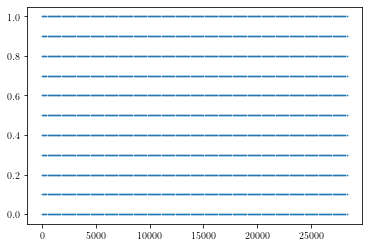

In [34]:
plt.scatter(mesh_VTU.points[:,0], mesh_VTU.points[:,1], s=0.5)

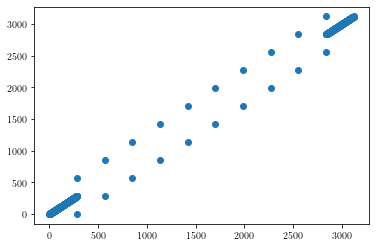

In [35]:
plt.scatter(mesh_VTU.cells[1].data[:,0], mesh_VTU.cells[1].data[:,1])

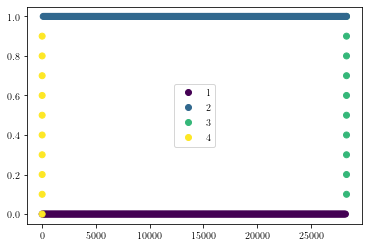

In [36]:
scat = plt.scatter(mesh_VTU.points[:,0][mesh_VTU.cells[1].data[:,0]], 
                   mesh_VTU.points[:,1][mesh_VTU.cells[1].data[:,1]], 
                   c = mesh_VTU.cell_data['GeometryIds'][1] - 100)

plt.legend(*scat.legend_elements())